In [105]:
import pandas as pd
pd.set_option('display.max_columns', None) # to display all columns
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# change column names to all lowercase
df.columns = map(str.lower, df.columns)

In [7]:
# convert "No / Yes" binary options to numerical 0s and 1s
binary_columns = ['partner', 'dependents', 'phoneservice', 'paperlessbilling', 'churn']
df[binary_columns] = df[binary_columns].eq('Yes').mul(1)

# convert the categorical variables that have numeric significance into numerical
df.multiplelines = df.multiplelines.map({'No phone service':0, 'No':1, 'Yes':2})
df.contract = df.contract.map({'Month-to-month':0, 'One year':1, 'Two year':2})

# convert "Male / Female" binary options to numerical 0s and 1s
df['gender'] = df['gender'].eq('Female').mul(1)

In [8]:
df = df.drop(columns = 'customerid') # drop 'customerid' column.
df['totalcharges'] = df['totalcharges'].replace(' ', np.nan, regex=True) # replaces blank to NaN
df = df.dropna() # drop the NaN values
df['totalcharges'] = df.totalcharges.astype(float) # converts to float

In [9]:
# create dummy variables
df = pd.get_dummies(df, drop_first=True, dtype=int)

## Run a vanilla model based upon the information given. Use that as a benchmark.


In [10]:
# Create features and labels
X = df.drop('churn', axis=1)  
y = df['churn'] 

# Perform an train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [75]:
# CREATING A PIPELINE
def pipeline(name_of_pipeline, classifier):
    '''Creates and displays the pipeline classifiers along with the report of metrics'''
    name_of_pipeline = Pipeline([('classifier', classifier)])
    name_of_pipeline.fit(X_train, y_train)
    y_pred_test = name_of_pipeline.predict(X_test)
    y_pred_train = name_of_pipeline.predict(X_train)
    
    report = classification_report(y_test, y_pred_test, output_dict=True)
    df = pd.DataFrame(report).transpose()
    
    print(df)
    print('\n\n')
    print(name_of_pipeline.fit(X_train, y_train))
    print('\n\n')
    print('Training Precision: ', round(precision_score(y_train, y_pred_train),3))
    print('Testing Precision: ', round(precision_score(y_test, y_pred_test),3))
    print('\n\n')
    print('Training Recall: ', round(recall_score(y_train, y_pred_train),3))
    print('Testing Recall: ', round(recall_score(y_test, y_pred_test),3))
    print('\n\n')
    print('Training Accuracy: ', round(accuracy_score(y_train, y_pred_train),3))
    print('Testing Accuracy: ', round(accuracy_score(y_test, y_pred_test),3))
    print('\n\n')
    print('Training F1-Score: ', round(f1_score(y_train, y_pred_train),3))
    print('Testing F1-Score: ', round(f1_score(y_test, y_pred_test),3))
    return

In [96]:
# CALL THE PIPELINE
pipeline('pipe_1', DecisionTreeClassifier(random_state=0, max_depth=4))

              precision    recall  f1-score      support
0              0.837715  0.890173  0.863148  1038.000000
1              0.625000  0.514905  0.564636   369.000000
accuracy       0.791756  0.791756  0.791756     0.791756
macro avg      0.731358  0.702539  0.713892  1407.000000
weighted avg   0.781929  0.791756  0.784860  1407.000000



Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(max_depth=4, random_state=0))])



Training Precision:  0.628
Testing Precision:  0.625



Training Recall:  0.541
Testing Recall:  0.515



Training Accuracy:  0.792
Testing Accuracy:  0.792



Training F1-Score:  0.581
Testing F1-Score:  0.565


In [157]:
def visualizing_confusionmatrix(name_of_pipeline, classifier, X_train, y_train, X_test, y_test):
    '''Creates confusion matrices of the results from classifier'''
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    name_of_pipeline = Pipeline([('classifier', classifier)])
    name_of_pipeline.fit(X_train, y_train)
    y_pred_test = name_of_pipeline.predict(X_test)
    y_pred_train = name_of_pipeline.predict(X_train)
    
    #Plot Training Confusion Matrix
    plot_confusion_matrix(classifier, X_train, y_train, ax=axes[0,0],
                          display_labels=["Did Not Churn","Churned"])
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    #Plot Normalized Training Confusion Matrix
    plot_confusion_matrix(classifier, X_train, y_train, ax=axes[1,0], 
                          display_labels=["Did Not Churn","Churned"],
                          normalize='true')
    
    #Plot Test Confusion Matrix
    plot_confusion_matrix(classifier, X_test, y_test, ax=axes[0,1],
                          display_labels=["Did Not Churn","Churned"])
    cm_test = confusion_matrix(y_test, y_pred_test)
    
    #Plot Normalized Test Confusion Matrix
    plot_confusion_matrix(classifier, X_test, y_test, ax=axes[1,1], 
                          display_labels=["Did Not Churn","Churned"],
                          normalize='true')
    
    axes[0,0].title.set_text(f'{classifier} Train')
    axes[0,1].title.set_text(f'{classifier} Test')
    axes[1,0].title.set_text(f'{classifier} Train')
    axes[1,1].title.set_text(f'{classifier} Test')
    
    plt.grid(False)
    plt.show()
    return

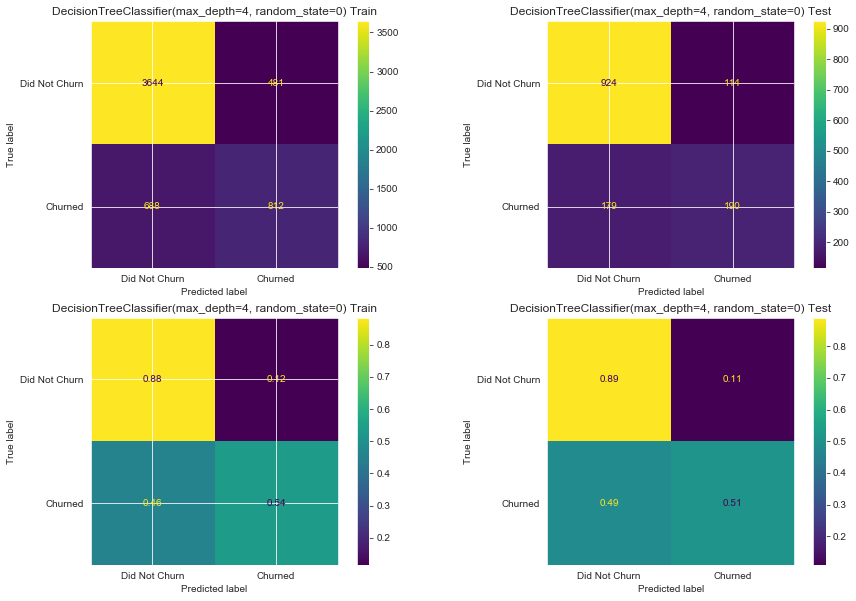

In [158]:
visualizing_confusionmatrix('pipe_1', DecisionTreeClassifier(random_state=0, max_depth=4), X_train, y_train, X_test, y_test)

> Notes: Need to figure out how to remove the grid axes in all of the subplots.

In [166]:
def createROCCurve(name_of_pipeline, classifier):
    '''Creates and plots the ROC'''
    name_of_pipeline = Pipeline([('classifier', classifier)])
    name_of_pipeline.fit(X_train, y_train)
    y_train_score = name_of_pipeline.predict(X_train)
    
    # Calculate the fpr, tpr, and thresholds for the training set
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)
    
    # Calculate the probability scores of each point in the test set
    y_test_score = name_of_pipeline.predict(X_test)
    
    # Calculate the fpr, tpr, and thresholds for the test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    
    plt.figure(figsize=(15, 10))
    lw = 2
    plt.plot(train_fpr, train_tpr, color='darkorange', lw=lw,
             label=('ROC curve for the trained data, AUC={:.3f}'.format(auc(test_fpr, test_tpr))))
    plt.plot(test_fpr, test_tpr, color='red', lw=lw,
             label=('ROC curve for the test data, AUC={:.3f}'.format(auc(train_fpr, train_tpr))))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('Receiver operating characteristic (ROC) Curve', fontsize=20)
    plt.legend(loc='lower right')
    plt.show()
    return

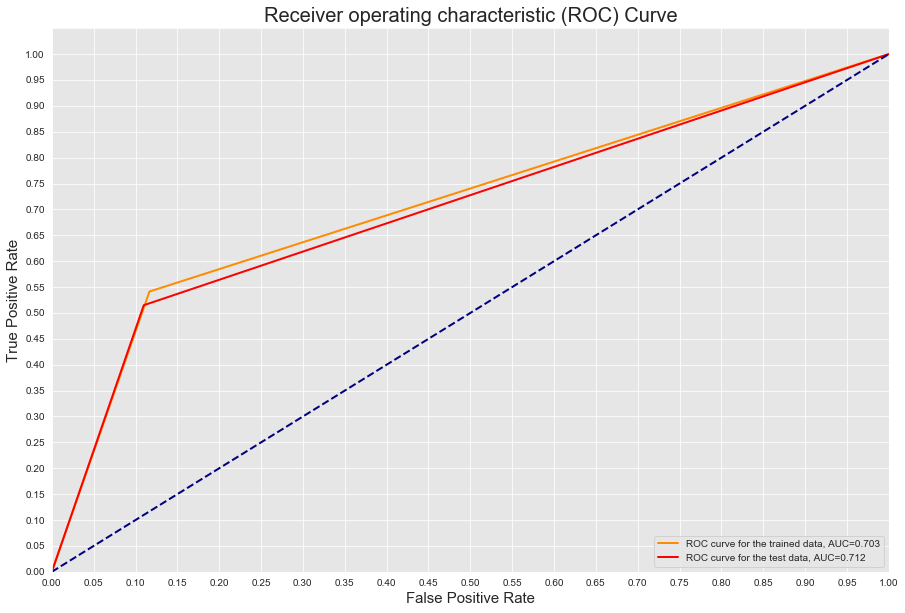

In [167]:
createROCCurve('pipe_1', DecisionTreeClassifier(random_state=0, max_depth=4))

## Results:
#### The baseline model is a Decision Tree
* The decision tree classifier has a max_depth=4
* Accuracy = 79.2%
* The baseline accuracy percentage of 79.2% in layman's terms means, "79.2% of customers were correctly classified by the model."
* Recall of the test data = 51.5%
* The baseline recall percentage of 51.5% in layman's terms means, "51.5% of customers who churned were correctly classified by the model."

## Goals:
#### Prioritize recall
* minimize Type II errors/false negatives
* minimize costly situations where the company reaches out to a customer that is falsely predicted to churn

## Next Steps:
1. Address class imbalance (SMOTE)
2. Simplify the model by identifying and reducing unimportant features:
 * Feature engineering
 * LASSO - least absolute shrinkage and selection operator - L1 Regularization
3. Attempt different types of modeling techniques
 * KNN
 * Random Forests
4. Hyperparameter tuning (GridSearch to create multiple models with different hyperparameters)

In [195]:
def create_decisiontree(name_of_pipeline, classifier):
    '''Creates and plots a decision tree'''
    name_of_pipeline = Pipeline([('classifier', classifier)])
    name_of_pipeline.fit(X_train, y_train)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,10), dpi=300)
    tree.plot_tree(classifier, fontsize=5, feature_names = df.columns,
                   class_names=np.unique(y).astype('str'), filled = True)
    for decision_box in tree.plot_tree(classifier, fontsize=5, feature_names = df.columns,
                   class_names=np.unique(y).astype('str'), filled = True):
        arrow = decision_box.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('red')
            arrow.set_linewidth(3)
    plt.show()
    return

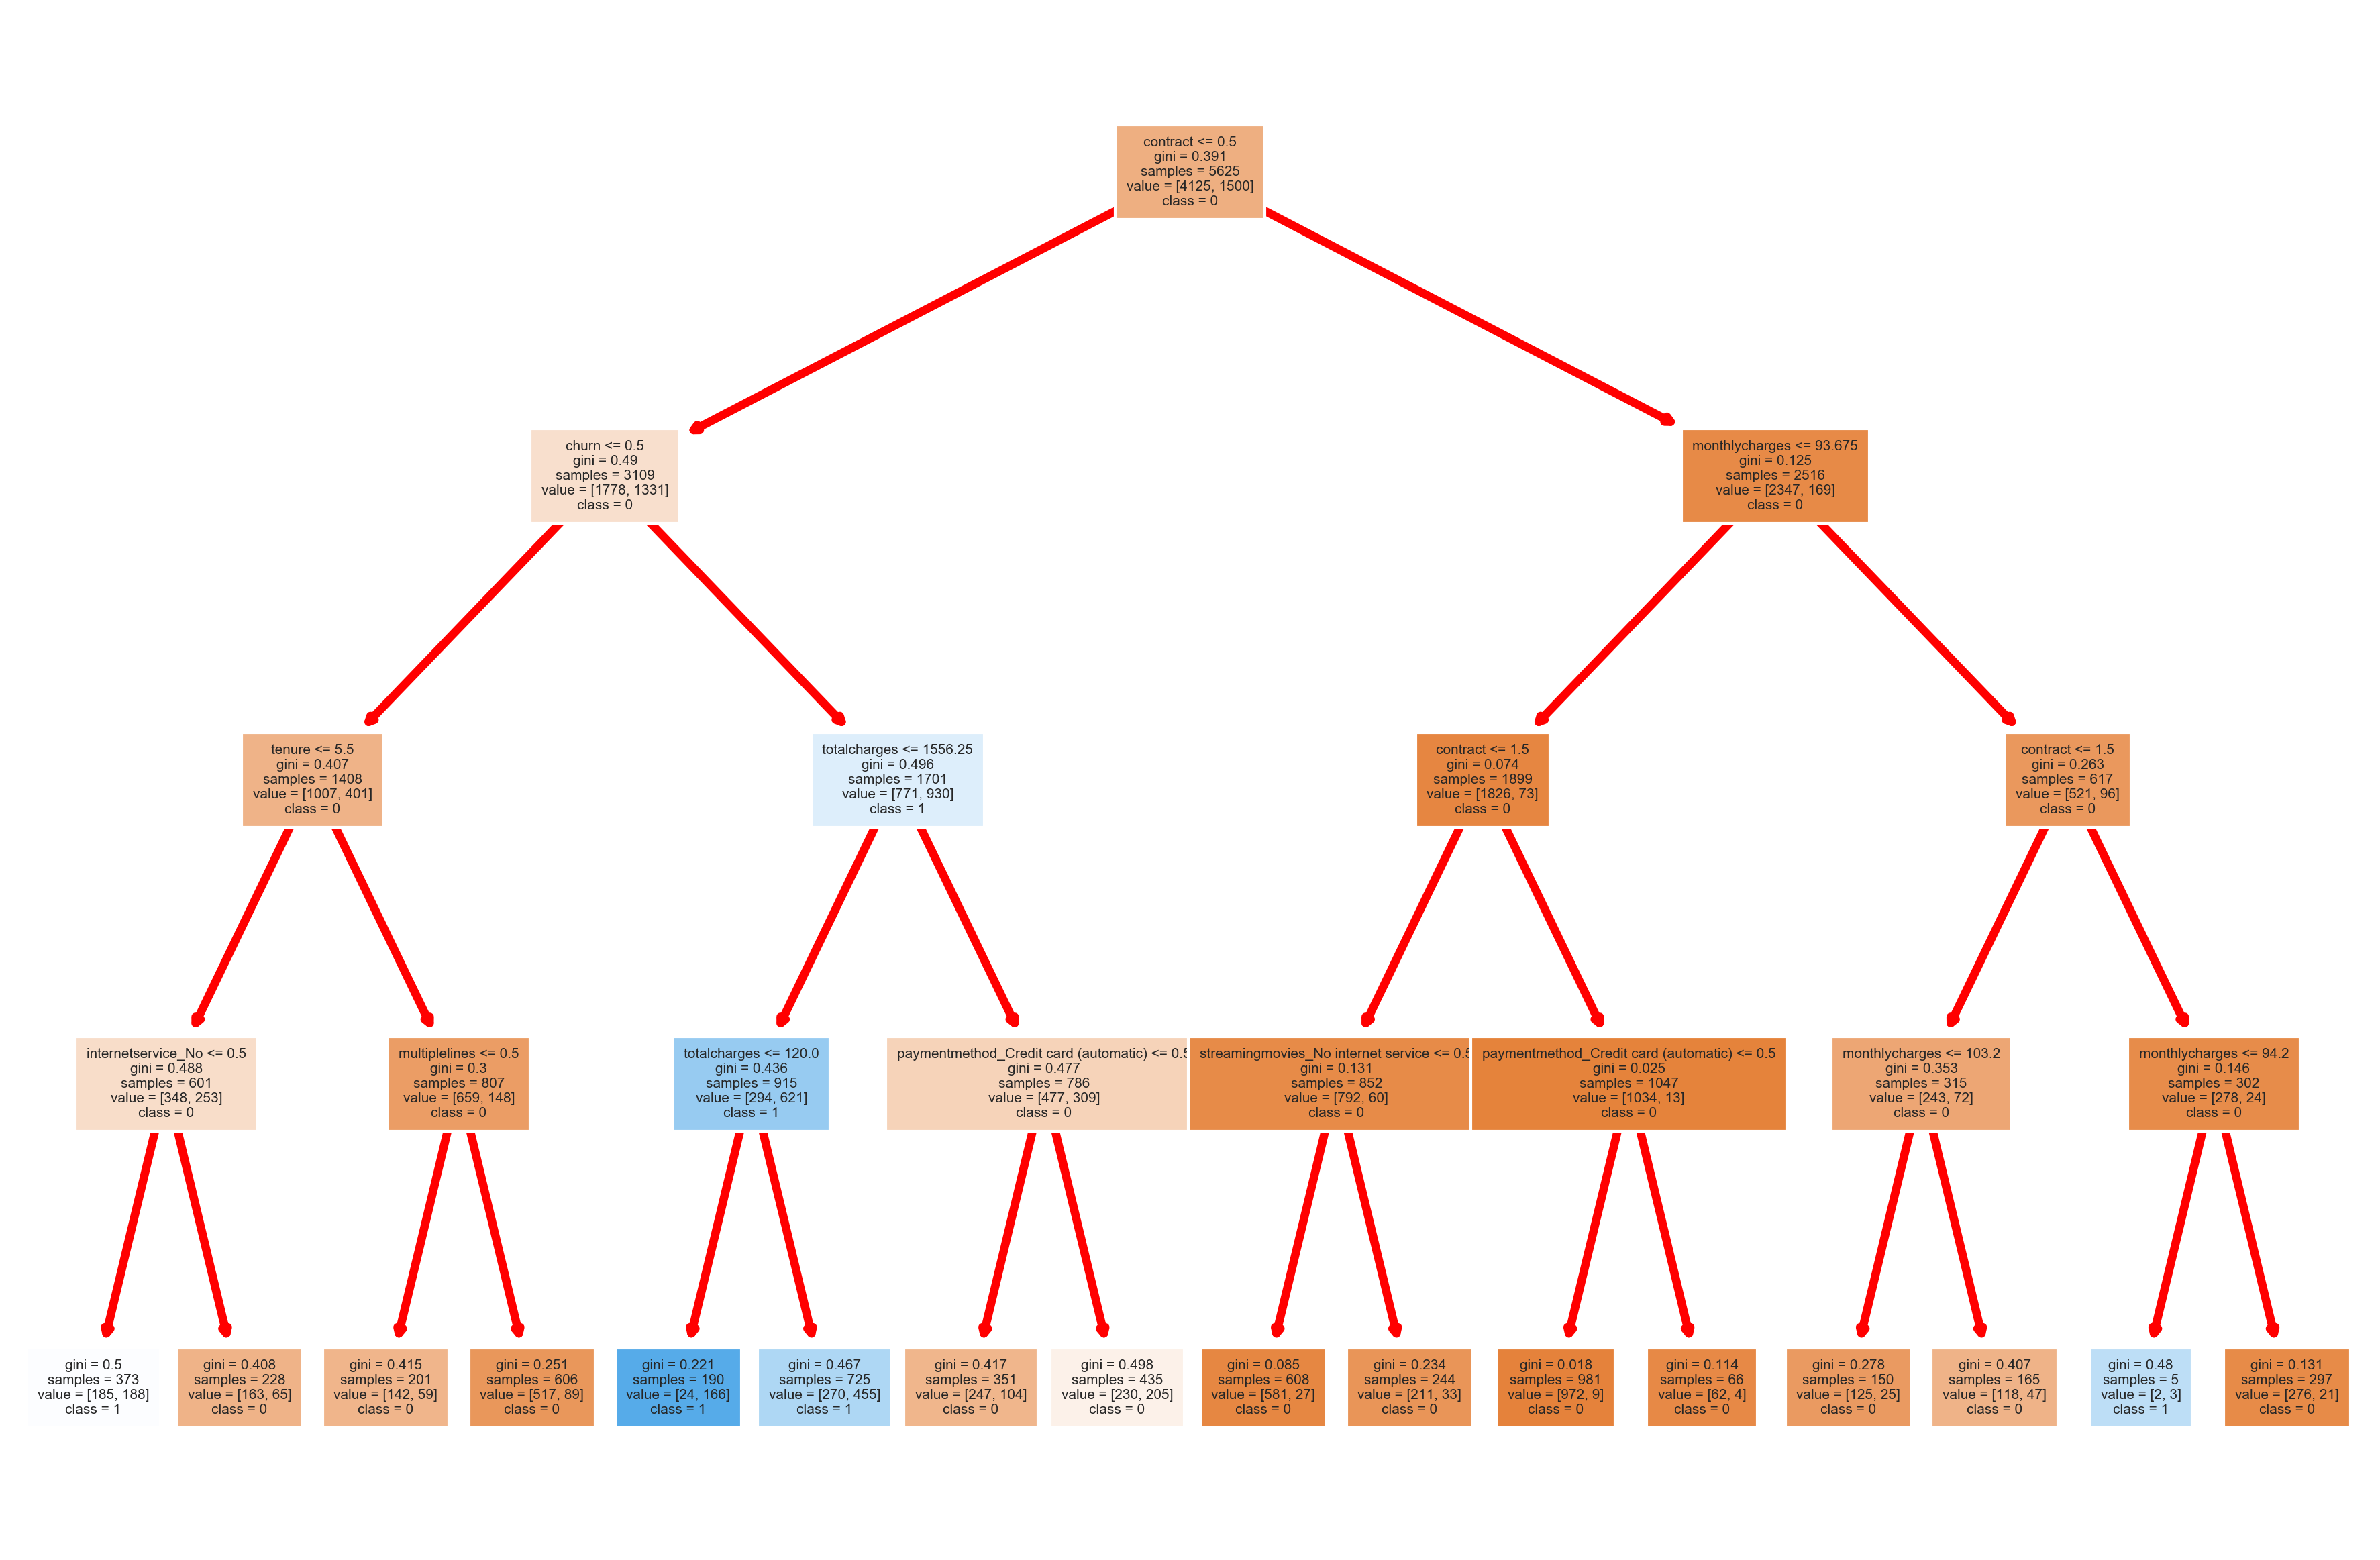

In [196]:
create_decisiontree('pipe_1', DecisionTreeClassifier(random_state=0, max_depth=4))

> Notes: I am not sure why 'contract' and 'monthlycharges' appears twice on the decision tree.